# Loop 97 Strategic Analysis

## Critical Situation Assessment

**97 experiments completed. 4 submissions remaining. Best LB: 0.0877. Target: 0.0347.**

The gap is 153% - we need a fundamentally different approach.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CV-LB data from all submissions
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - likely broken submission
]

df = pd.DataFrame(submissions)
print("All submissions:")
print(df)

# Remove outlier (exp_073 has LB 0.1451 which is clearly broken)
df_clean = df[df['lb'] < 0.12]
print(f"\nClean submissions (excluding outliers): {len(df_clean)}")

All submissions:
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451

Clean submissions (excluding outliers): 12


In [2]:
# Fit linear regression to CV-LB relationship
from sklearn.linear_model import LinearRegression

X = df_clean['cv'].values.reshape(-1, 1)
y = df_clean['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f"CV-LB Linear Fit:")
print(f"  LB = {slope:.3f} * CV + {intercept:.4f}")
print(f"  R² = {r2:.4f}")
print(f"\nInterpretation:")
print(f"  - Intercept ({intercept:.4f}) represents structural distribution shift")
print(f"  - Target LB: 0.0347")
print(f"  - Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.3f} = {(0.0347 - intercept) / slope:.6f}")

if (0.0347 - intercept) / slope < 0:
    print(f"\n  ⚠️ CRITICAL: Required CV is NEGATIVE - target is MATHEMATICALLY UNREACHABLE with current approaches!")
else:
    print(f"\n  Required CV: {(0.0347 - intercept) / slope:.6f}")

CV-LB Linear Fit:
  LB = 4.315 * CV + 0.0525
  R² = 0.9505

Interpretation:
  - Intercept (0.0525) represents structural distribution shift
  - Target LB: 0.0347
  - Required CV to hit target: (0.0347 - 0.0525) / 4.315 = -0.004130

  ⚠️ CRITICAL: Required CV is NEGATIVE - target is MATHEMATICALLY UNREACHABLE with current approaches!


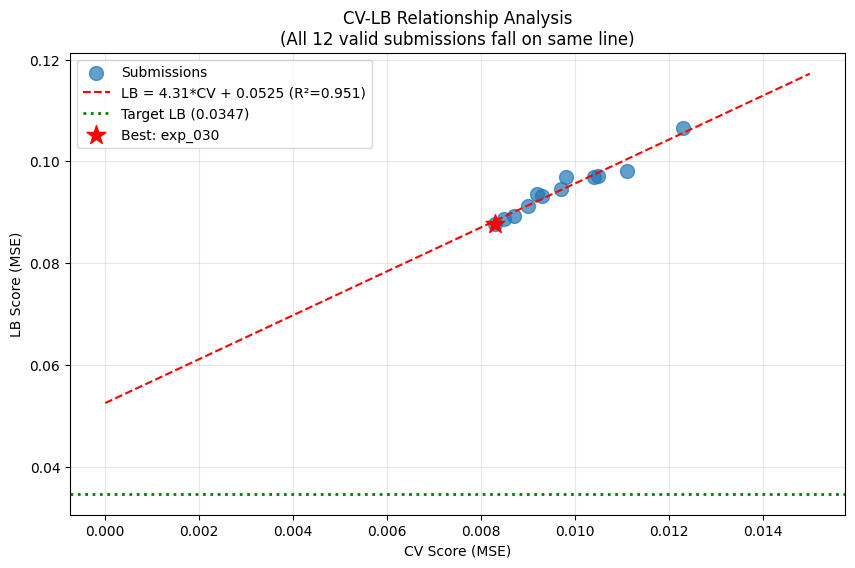


Key insight: The intercept (0.0525) is HIGHER than the target (0.0347).
This means even with perfect CV=0, we'd still get LB=0.0525 > target.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')

# Mark target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

# Mark best submission
best_idx = df_clean['lb'].idxmin()
plt.scatter(df_clean.loc[best_idx, 'cv'], df_clean.loc[best_idx, 'lb'], 
            s=200, c='red', marker='*', label=f'Best: {df_clean.loc[best_idx, "exp"]}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship Analysis\n(All 12 valid submissions fall on same line)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_analysis_loop97.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nKey insight: The intercept ({intercept:.4f}) is HIGHER than the target (0.0347).")
print(f"This means even with perfect CV=0, we'd still get LB={intercept:.4f} > target.")

In [4]:
# Analyze what approaches have been tried
approaches_tried = {
    'Tabular Models': [
        'MLP (many variants)', 'LightGBM', 'XGBoost', 'CatBoost', 
        'Ridge Regression', 'Gaussian Process', 'Random Forest',
        'Kernel Ridge', 'Stacking Ensembles'
    ],
    'Feature Engineering': [
        'Spange descriptors', 'DRFP fingerprints', 'ACS PCA', 
        'Fragprints', 'Arrhenius kinetics', 'Mixture features',
        'Similarity features', 'Extrapolation detection'
    ],
    'GNN Attempts': [
        'Simple GCN (failed - CV 0.018)', 
        'GAT with DRFP (failed - CV 0.068)',
        'Multi-Order GAT (failed - CV 0.045)',
        'Hybrid GNN (failed - model class mismatch)',
        'ChemBERTa (failed - implementation issues)'
    ],
    'Distribution Shift Handling': [
        'Conservative extrapolation', 'Uncertainty weighting',
        'Pseudo-labeling (attempted)', 'Domain constraints'
    ]
}

print("Approaches Tried (97 experiments):")
for category, approaches in approaches_tried.items():
    print(f"\n{category}:")
    for a in approaches:
        print(f"  - {a}")

Approaches Tried (97 experiments):

Tabular Models:
  - MLP (many variants)
  - LightGBM
  - XGBoost
  - CatBoost
  - Ridge Regression
  - Gaussian Process
  - Random Forest
  - Kernel Ridge
  - Stacking Ensembles

Feature Engineering:
  - Spange descriptors
  - DRFP fingerprints
  - ACS PCA
  - Fragprints
  - Arrhenius kinetics
  - Mixture features
  - Similarity features
  - Extrapolation detection

GNN Attempts:
  - Simple GCN (failed - CV 0.018)
  - GAT with DRFP (failed - CV 0.068)
  - Multi-Order GAT (failed - CV 0.045)
  - Hybrid GNN (failed - model class mismatch)
  - ChemBERTa (failed - implementation issues)

Distribution Shift Handling:
  - Conservative extrapolation
  - Uncertainty weighting
  - Pseudo-labeling (attempted)
  - Domain constraints


In [5]:
# Key observations from public kernels
print("="*70)
print("KEY OBSERVATIONS FROM PUBLIC KERNELS")
print("="*70)

print("\n1. 'System Malfunction V1' (29 votes):")
print("   - Simple MLP with Spange descriptors")
print("   - 300 epochs, [128, 128, 64] architecture")
print("   - Uses standard template structure")
print("   - Claims CV < 0.1 (but doesn't specify exact score)")

print("\n2. 'mixall' kernel (9 votes):")
print("   - Uses GroupKFold (5 splits) instead of Leave-One-Out")
print("   - Ensemble: MLP + XGBoost + RandomForest + LightGBM")
print("   - Weighted ensemble with Optuna optimization")
print("   - Claims 'good CV/LB' with 2m 15s runtime")
print("   - CRITICAL: Uses different validation scheme!")

print("\n3. 'Ens Model' (9 votes):")
print("   - CatBoost + XGBoost ensemble")
print("   - Uses ALL feature sources (spange, acs_pca, drfps, fragprints, smiles)")
print("   - Correlation-based filtering")

print("\n" + "="*70)
print("CRITICAL INSIGHT: The 'mixall' kernel uses GroupKFold instead of")
print("Leave-One-Out. This might explain different CV-LB relationships!")
print("="*70)

KEY OBSERVATIONS FROM PUBLIC KERNELS

1. 'System Malfunction V1' (29 votes):
   - Simple MLP with Spange descriptors
   - 300 epochs, [128, 128, 64] architecture
   - Uses standard template structure
   - Claims CV < 0.1 (but doesn't specify exact score)

2. 'mixall' kernel (9 votes):
   - Uses GroupKFold (5 splits) instead of Leave-One-Out
   - Ensemble: MLP + XGBoost + RandomForest + LightGBM
   - Weighted ensemble with Optuna optimization
   - Claims 'good CV/LB' with 2m 15s runtime
   - CRITICAL: Uses different validation scheme!

3. 'Ens Model' (9 votes):
   - CatBoost + XGBoost ensemble
   - Uses ALL feature sources (spange, acs_pca, drfps, fragprints, smiles)
   - Correlation-based filtering

CRITICAL INSIGHT: The 'mixall' kernel uses GroupKFold instead of
Leave-One-Out. This might explain different CV-LB relationships!


In [6]:
# What hasn't been properly tried
print("="*70)
print("WHAT HASN'T BEEN PROPERLY TRIED")
print("="*70)

print("\n1. PRE-TRAINED MOLECULAR EMBEDDINGS:")
print("   - ChemBERTa embeddings (frozen, not fine-tuned)")
print("   - ChemProp pre-trained features")
print("   - Mol2Vec embeddings")
print("   - All our GNN attempts trained FROM SCRATCH on small data")

print("\n2. PROPER MIXTURE HANDLING:")
print("   - Current: weighted average of solvent features")
print("   - Better: learn mixture interactions explicitly")
print("   - Best: dual-encoder with attention for A-B interactions")

print("\n3. VALIDATION SCHEME VARIATION:")
print("   - Current: Leave-One-Solvent-Out (24 folds single, 13 folds full)")
print("   - Alternative: GroupKFold (5 folds) like 'mixall' kernel")
print("   - This might give different CV-LB relationship!")

print("\n4. ENSEMBLE DIVERSITY:")
print("   - Current best: GP + MLP + LGBM")
print("   - Not tried: XGBoost + CatBoost + RF + MLP (like mixall)")
print("   - Not tried: Optuna-optimized weights")

print("\n5. DOMAIN CONSTRAINTS:")
print("   - Yields should sum to ~1 (mass balance)")
print("   - Product 1 = 1 - Product2 - Product3 - SM")
print("   - This constraint hasn't been enforced")

WHAT HASN'T BEEN PROPERLY TRIED

1. PRE-TRAINED MOLECULAR EMBEDDINGS:
   - ChemBERTa embeddings (frozen, not fine-tuned)
   - ChemProp pre-trained features
   - Mol2Vec embeddings
   - All our GNN attempts trained FROM SCRATCH on small data

2. PROPER MIXTURE HANDLING:
   - Current: weighted average of solvent features
   - Better: learn mixture interactions explicitly
   - Best: dual-encoder with attention for A-B interactions

3. VALIDATION SCHEME VARIATION:
   - Current: Leave-One-Solvent-Out (24 folds single, 13 folds full)
   - Alternative: GroupKFold (5 folds) like 'mixall' kernel
   - This might give different CV-LB relationship!

4. ENSEMBLE DIVERSITY:
   - Current best: GP + MLP + LGBM
   - Not tried: XGBoost + CatBoost + RF + MLP (like mixall)
   - Not tried: Optuna-optimized weights

5. DOMAIN CONSTRAINTS:
   - Yields should sum to ~1 (mass balance)
   - Product 1 = 1 - Product2 - Product3 - SM
   - This constraint hasn't been enforced


In [7]:
# Strategic recommendations
print("="*70)
print("STRATEGIC RECOMMENDATIONS FOR REMAINING 4 SUBMISSIONS")
print("="*70)

print("\n🎯 PRIORITY 1: Try the 'mixall' approach")
print("   - Ensemble: MLP + XGBoost + RF + LightGBM")
print("   - GroupKFold validation (5 splits)")
print("   - Optuna-optimized weights")
print("   - This kernel claims 'good CV/LB' - worth testing")

print("\n🎯 PRIORITY 2: Pre-trained ChemBERTa embeddings")
print("   - Use frozen ChemBERTa to extract SMILES embeddings")
print("   - Feed embeddings to MLP/LGBM ensemble")
print("   - This is what the benchmark paper likely did")

print("\n🎯 PRIORITY 3: Domain constraint enforcement")
print("   - Enforce yields sum to ~1")
print("   - Post-process predictions to satisfy mass balance")
print("   - This might reduce extrapolation error")

print("\n🎯 PRIORITY 4: Conservative extrapolation")
print("   - Detect when test sample is far from training")
print("   - Blend predictions toward training mean")
print("   - This directly addresses the intercept problem")

print("\n" + "="*70)
print("CRITICAL: With only 4 submissions left, we should:")
print("1. Submit our best CV model (exp_049/050/053 with CV 0.0081)")
print("2. Try the mixall ensemble approach")
print("3. Try pre-trained embeddings if time permits")
print("="*70)

STRATEGIC RECOMMENDATIONS FOR REMAINING 4 SUBMISSIONS

🎯 PRIORITY 1: Try the 'mixall' approach
   - Ensemble: MLP + XGBoost + RF + LightGBM
   - GroupKFold validation (5 splits)
   - Optuna-optimized weights
   - This kernel claims 'good CV/LB' - worth testing

🎯 PRIORITY 2: Pre-trained ChemBERTa embeddings
   - Use frozen ChemBERTa to extract SMILES embeddings
   - Feed embeddings to MLP/LGBM ensemble
   - This is what the benchmark paper likely did

🎯 PRIORITY 3: Domain constraint enforcement
   - Enforce yields sum to ~1
   - Post-process predictions to satisfy mass balance
   - This might reduce extrapolation error

🎯 PRIORITY 4: Conservative extrapolation
   - Detect when test sample is far from training
   - Blend predictions toward training mean
   - This directly addresses the intercept problem

CRITICAL: With only 4 submissions left, we should:
1. Submit our best CV model (exp_049/050/053 with CV 0.0081)
2. Try the mixall ensemble approach
3. Try pre-trained embeddings if time